<a href="https://colab.research.google.com/github/alfozan/mlflow-example/blob/master/MLflow-example-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLflow Example Notebook

## Repo: https://github.com/alfozan/mlflow-example
---

This notebook demonstrates an example of dataset preprocessing, ML model training and evaluation, model tuning via MLflow tracking and finally REST API model serving via MLflow models.

- **Talks:** https://twitter.com/PyDataRiyadh/status/1291043529146466304 and https://twitter.com/PyDataRiyadh/status/1314841078999154689?s=20
- **Author:** Abdulrahman Alfozan ([@alfozan](https://twitter.com/alfozan)), [github](https://github.com/alfozan)
---
- **Dateset:** Bike Sharing Dataset: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- **Goal:** predict `rented_bikes` (count per hour) based on weather and time information.


**References:**
- https://docs.databricks.com/_static/notebooks/gbt-regression.html
- https://www.kaggle.com/pratsiuk/mlflow-experiment-automation-top-9
- https://mlflow.org/docs/latest/tracking.html

# Import Libraries


In [1]:
!pip install pydotplus

In [1]:
!pip install mlflow --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from mlflow.models.signature import infer_signature
from sklearn import tree

from pydotplus import graph_from_dot_data
import graphviz
from IPython.display import Image

import itertools

plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

# Import Data

Dataset and explanation:
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

- Input file: `hour.csv` - contains bike sharing counts aggregated on hourly basis. 
- Size: 17379 hours / rows


In [2]:
# load input data into pandas dataframe
bike_sharing = pd.read_csv("data/hour.csv")
bike_sharing        

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


## Data preprocessing

In [3]:
# remove unused columns
bike_sharing.drop(columns=["instant", "dteday", "registered", "casual"], inplace=True)

# use better names
bike_sharing.rename(
    columns={
        "yr": "year",
        "mnth": "month",
        "hr": "hour_of_day",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "weathersit": "weather_situation",
        "temp": "temperature",
        "atemp": "feels_like_temperature",
        "hum": "humidity",
        "cnt": "rented_bikes",
    },
    inplace=True,
)

# show samples
bike_sharing

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61


### Data Visualization 

<AxesSubplot:title={'center':'Total rented bikes by hour of day'}, xlabel='hour_of_day'>

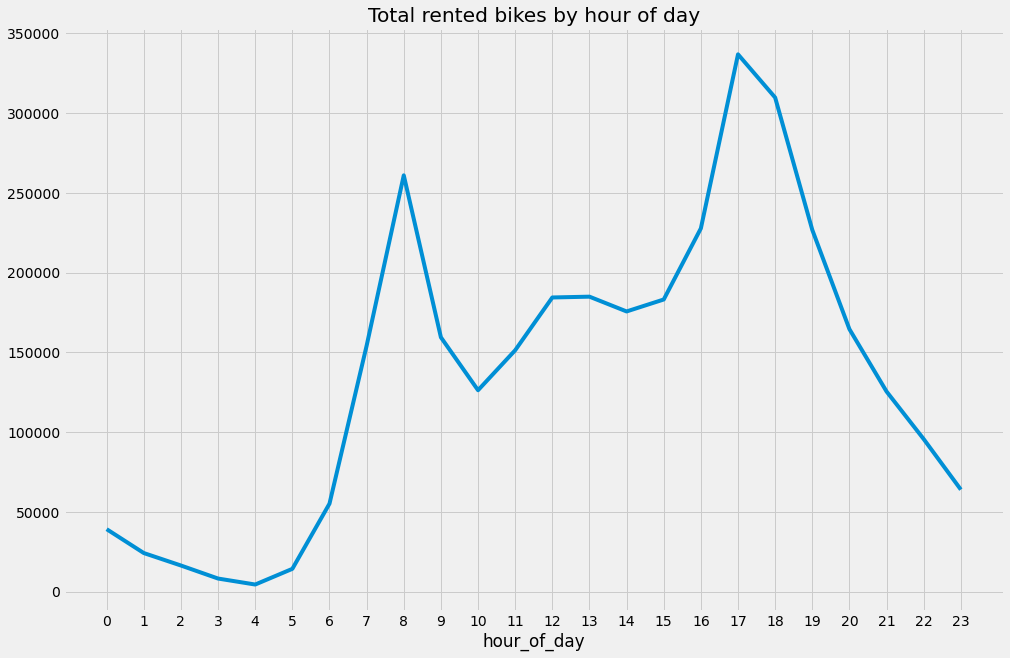

In [4]:
hour_of_day_agg = bike_sharing.groupby(["hour_of_day"])["rented_bikes"].sum()

hour_of_day_agg.plot(
    kind="line", 
    title="Total rented bikes by hour of day",
    xticks=hour_of_day_agg.index,
    figsize=(15, 10),
)

## Prepare training and test data sets


In [5]:
# Split the dataset randomly into 70% for training and 30% for testing.
X = bike_sharing.drop("rented_bikes", axis=1)
y = bike_sharing.rented_bikes
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

print(f"Training samples: {X_train.size}")
print(f"Test samples: {X_test.size}")

Training samples: 145980
Test samples: 62568


# Evaluation Metrics

Create evaluation methods to be used in training stage (next step)

## Root Mean Square Error (RMSE)

References: 
- https://medium.com/@xaviergeerinck/artificial-intelligence-how-to-measure-performance-accuracy-precision-recall-f1-roc-rmse-611d10e4caac
- https://www.kaggle.com/residentmario/model-fit-metrics#Root-mean-squared-error-(RMSE)


In [6]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def rmse_score(y, y_pred):
    score = rmse(y, y_pred)
    print("RMSE score: {:.4f}".format(score))
    return score

### Cross-Validation RMSLE score

cross-validation combines (averages) measures of fitness in prediction to derive a more accurate estimate of model prediction performance.

Background: 
- https://en.wikipedia.org/wiki/Cross-validation_(statistics)
- https://www.kaggle.com/carlolepelaars/understanding-the-metric-rmsle


In [7]:
def rmsle_cv(model, X_train, y_train):
    kf = KFold(n_splits=3, shuffle=True, random_state=42).get_n_splits(X_train.values)
    # Evaluate a score by cross-validation
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse


def rmse_cv_score(model, X_train, y_train):
    score = rmsle_cv(model, X_train, y_train)
    print("Cross-Validation RMSE score: {:.4f} (std = {:.4f})".format(score.mean(), score.std()))
    return score

## Feature Importance

Background: https://medium.com/bigdatarepublic/feature-importance-whats-in-a-name-79532e59eea3

In [8]:
def model_feature_importance(model):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=X_train.columns,
        columns=["Importance"],
    )

    # sort by importance
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")
    # save image
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')

## Permutation Importance

Background: https://www.kaggle.com/dansbecker/permutation-importance

In [9]:
def model_permutation_importance(model):
    p_importance = permutation_importance(model, X_test, y_test, random_state=42, n_jobs=-1)

    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=X_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    plt.savefig("model_artifacts/permutation_importance.png", bbox_inches="tight")

## Decision Tree Visualization

Reference: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc 


TODO: plot all trees

In [10]:
def model_tree_visualization(model):
    # generate visualization
    tree_dot_data = tree.export_graphviz(
        decision_tree=model.estimators_[0, 0],  # Get the first tree,
        label="all",
        feature_names=X_train.columns,
        filled=True,
        rounded=True,
        proportion=True,
        impurity=False,
        precision=1,
    )

    # save image
    graph_from_dot_data(tree_dot_data).write_png("model_artifacts/Decision_Tree_Visualization.png")

    # show tree
    return graphviz.Source(tree_dot_data)

# MLflow Tracking

Reference: https://www.mlflow.org/docs/latest/cli.html#mlflow-ui


## MLflow Logger

In [11]:
# Track params and metrics
def log_mlflow_run(model, signature):
    # Auto-logging for scikit-learn estimators
    # mlflow.sklearn.autolog()

    # log estimator_name name
    name = model.__class__.__name__
    mlflow.set_tag("estimator_name", name)

    # log input features
    mlflow.set_tag("features", str(X_train.columns.values.tolist()))

    # Log tracked parameters only
    mlflow.log_params({key: model.get_params()[key] for key in parameters})

    mlflow.log_metrics({
        'RMSE_CV': score_cv.mean(),
        'RMSE': score,
    })

    # log training loss
    for s in model.train_score_:
        mlflow.log_metric("Train Loss", s)

    # Save model to artifacts
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # log charts
    mlflow.log_artifacts("model_artifacts")

    # misc
    # Log all model parameters
    # mlflow.log_params(model.get_params())
    # mlflow.log_param("Training size", X_test.size)
    # mlflow.log_param("Test size", y_test.size)

## Initialize MLflow experiment

In [17]:
experiment_name = "rented_bikes"

mlflow.set_experiment(experiment_name)
mlflow.set_tracking_uri("./mlruns")

# delete default experiment if exits
if (mlflow.get_experiment_by_name("Default").lifecycle_stage == 'active'):
    mlflow.delete_experiment("0")



## Start experiments tracking UI

### MLflow UI URL

Note: you can download `/content/mlruns` folder and run `mlflow ui` locally

Steps:
- Download `/content/mlruns` folder to `~/Downloads`
- `cd ~/Downloads && pip install mlflow && mlflow ui`

Reference: https://www.mlflow.org/docs/latest/quickstart.html#viewing-the-tracking-ui


# Model Training


## Model Type & Method

For this example,
- Approache: Decision tree (Supervised learning)
- Tree type: Regression tree
- Technique/ensemble method: Gradient boosting

**All put together we get:** [GBRT (Gradient Boosted Regression Tree)](https://orbi.uliege.be/bitstream/2268/163521/1/slides.pdf)

Background:
- Choosing a model: https://scikit-learn.org/stable/tutorial/machine_learning_map
- Machine Learning Models Explained
: https://docs.paperspace.com/machine-learning/wiki/machine-learning-models-explained
- Gradient Boosted Regression Trees: https://orbi.uliege.be/bitstream/2268/163521/1/slides.pdf


In [18]:
# GBRT (Gradient Boosted Regression Tree) scikit-learn implementation 
model_class = GradientBoostingRegressor

## Model Hyper-parameters 


In [19]:
parameters = {
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [4, 5, 6],
    # "verbose": True,
}

### Tuning the hyper-parameters: Grid search

- Simple but inefficient
- more advanced tuning techniques: https://research.fb.com/efficient-tuning-of-online-systems-using-bayesian-optimization/

In [20]:
# generate parameters combinations
params_keys = parameters.keys()
params_values = [
    parameters[key] if isinstance(parameters[key], list) else [parameters[key]]
    for key in params_keys
]
runs_parameters = [
    dict(zip(params_keys, combination)) for combination in itertools.product(*params_values)
]

## Training runs

In [15]:
# training loop
for i, run_parameters in enumerate(runs_parameters):
    print(f"Run {i}: {run_parameters}")

    # mlflow: stop active runs if any
    if mlflow.active_run():
        mlflow.end_run()
    # mlflow:track run
    mlflow.start_run(run_name=f"Run {i}")

    # create model instance
    model = model_class(**run_parameters)

    # train
    model.fit(X_train, y_train)

    # get evaluations scores
    score = rmse_score(y_test, model.predict(X_test))
    score_cv = rmse_cv_score(model, X_train, y_train)
    
    # generate charts
    model_feature_importance(model)
    plt.close()
    model_permutation_importance(model)
    plt.close()
    #model_tree_visualization(model)

    # get model signature
    signature = infer_signature(model_input=X_train, model_output=model.predict(X_train))

    # mlflow: log metrics
    log_mlflow_run(model, signature)

    # mlflow: end tracking
    mlflow.end_run()
    print("")

Run 0: {'learning_rate': 0.1, 'max_depth': 4}


MlflowException: Could not create run under non-active experiment with ID 0.

# Best Model Results

In [21]:
best_run_df = mlflow.search_runs(order_by=['metrics.RMSE_CV ASC'], max_results=1)
if len(best_run_df.index) == 0:
    raise Exception(f"Found no runs for experiment '{experiment_name}'")

best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
best_model = mlflow.sklearn.load_model(best_model_uri)

In [22]:
# print best run info
print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print(f"Run parameters: {best_run.data.params}")
print("Run score: RMSE_CV = {:.4f}".format(best_run.data.metrics['RMSE_CV']))
print(f"Run model URI: {best_model_uri}")

Best run info:
Run id: f4ee4f1832bf4f0c8b282b3216b16bf8
Run parameters: {'learning_rate': '0.1', 'max_depth': '6'}
Run score: RMSE_CV = 44.9746
Run model URI: file:///C:/Users/debjy/Downloads/mlflow-example-main/mlruns/1/f4ee4f1832bf4f0c8b282b3216b16bf8/artifacts/model


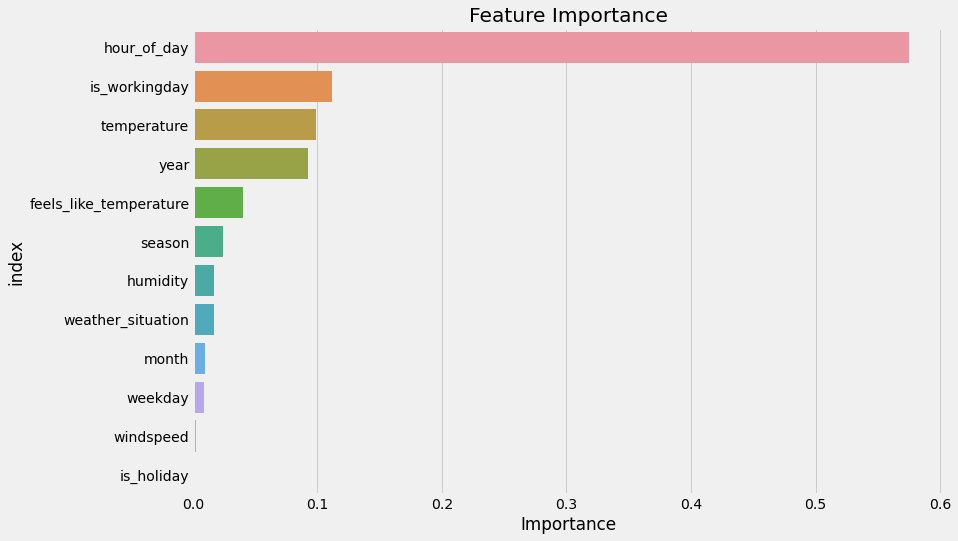

In [23]:
model_feature_importance(best_model)

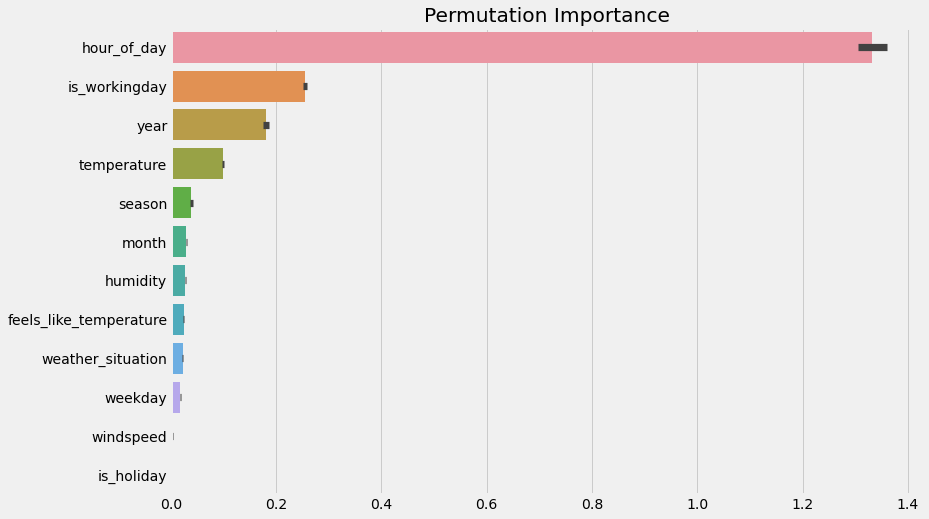

In [24]:
model_permutation_importance(best_model)

# Inference

In [25]:
test_predictions = X_test.copy()
# real output (rented_bikes) from test dataset
test_predictions["rented_bikes"] = y_test

# add "predicted_rented_bikes" from test dataset
test_predictions["predicted_rented_bikes"] = best_model.predict(X_test).astype(int)

# show results
test_predictions

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes,predicted_rented_bikes
12830,3,1,6,19,0,6,0,1,0.80,0.6970,0.27,0.1940,425,397
8688,1,1,1,20,1,1,0,1,0.24,0.2273,0.41,0.2239,88,99
7091,4,0,10,2,0,5,1,1,0.32,0.3030,0.66,0.2836,4,13
12230,2,1,5,19,0,2,1,1,0.78,0.7121,0.52,0.3582,526,564
431,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881,13,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12749,2,1,6,10,0,3,1,1,0.82,0.7727,0.52,0.1343,167,182
11476,2,1,4,9,0,6,0,2,0.38,0.3939,0.37,0.0000,214,241
12847,3,1,6,12,0,0,0,1,0.80,0.6970,0.33,0.2239,556,555
16721,4,1,12,12,0,2,1,1,0.52,0.5000,0.68,0.1940,312,297


<AxesSubplot:title={'center':'Rented bikes vs predicted rented bikes'}, xlabel='rented_bikes', ylabel='predicted_rented_bikes'>

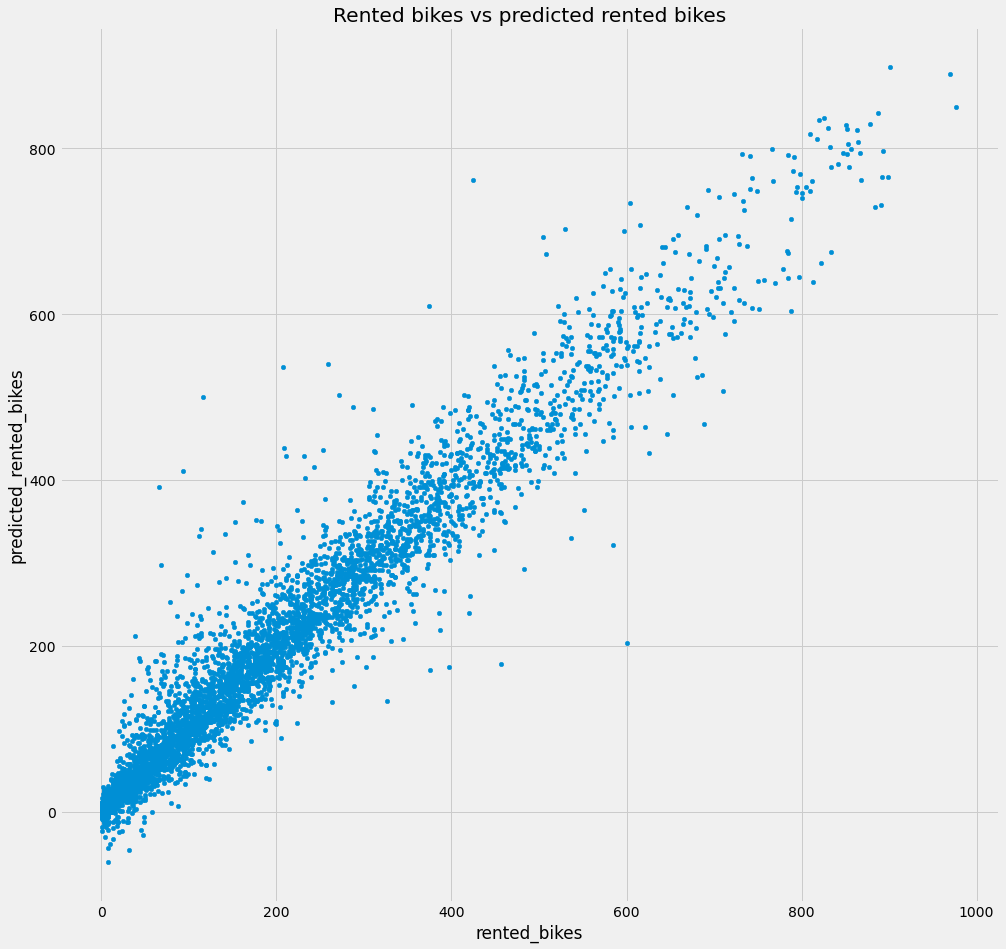

In [24]:
# plot truth vs prediction values
test_predictions.plot(
    kind="scatter",
    x="rented_bikes",
    y="predicted_rented_bikes",
    title="Rented bikes vs predicted rented bikes",
    figsize=(15, 15),
)

# Model Serving

Reference: https://www.mlflow.org/docs/latest/models.html

In [ ]:
get_ipython().system_raw(f"mlflow models serve --model-uri {best_model_uri} --host 0.0.0.0 --port 5001 --workers 1 --no-conda &")
!sleep 5

In [26]:
best_model_uri

'file:///C:/Users/debjy/Downloads/mlflow-example-main/mlruns/1/f4ee4f1832bf4f0c8b282b3216b16bf8/artifacts/model'

In [ ]:
# alternative method
# import mlflow.models.cli
# mlflow.models.cli.serve(["--model-uri", best_model_uri, "--no-conda", "--host", "0.0.0.0", "--port", 5005, "--workers", 1])

### REST API request

In [39]:
import requests

headers = {
    # Already added when you pass json= but not when you pass data=
    # 'Content-Type': 'application/json',
}

json_data = {
    'columns': [
        'season',
        'year',
        'month',
        'hour_of_day',
        'is_holiday',
        'weekday',
        'is_workingday',
        'weather_situation',
        'temperature',
        'feels_like_temperature',
        'humidity',
        'windspeed',
    ],
    'data': [
        [
            1,
            0,
            1,
            0,
            0,
            6,
            0,
            1,
            0.24,
            0.2879,
            0.81,
            0,
        ],
    ],
}

response = requests.post('http://localhost:5001/invocations', headers=headers, json=json_data)

In [41]:

response.json()

[35.61620094805556]

In [ ]:
%%bash
curl --silent --show-error 'http://localhost:5001/invocations' -H 'Content-Type: application/json' -d '{
    "columns": ["season", "year", "month", "hour_of_day", "is_holiday", "weekday", "is_workingday", "weather_situation", "temperature", "feels_like_temperature", "humidity", "windspeed"],
    "data": [[1, 0, 1, 0, 0, 6, 0, 1, 0.24, 0.2879, 0.81, 0.0000]]
}'